In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/newparticulate_covidstat.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpm10_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = in_datapaper
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   ferrara
   2   ragusa
   3   caltanissetta
   4   mantova
   5   varese
   6   como
   7   vercelli
   8   belluno
   9   potenza
   10   rovigo
   11   reggio_di_calabria
   12   catanzaro
   13   rieti
   14   livorno
   15   carbonia
   16   udine
   17   torino
   18   monza
   19   l_aquila
   20   napoli
   21   cuneo
   22   genova
   23   alessandria
   24   sondrio
   25   imperia
   26   oristano
   27   foggia
   28   massa
   29   pisa
   30   crotone
   31   ravenna
   32   terni
   33   chieti
   34   reggio_nell_emilia
   35   asti
   36   pesaro
   37   palermo
   38   lecco
   39   cremona
   40   taranto
   41   lecce
   42   trapani
   43   pescara
   44   brindisi
   45   pordenone
   46   benevento
   47   modena
   48   enna
   49   treviso
   50   brescia
   51   roma
   52   siena
   53   forli
   54   salerno
   55   vibo_valentia
   56   isernia
   57   la_spezia
   58   grosseto


In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 ferrara
2 ragusa
3 caltanissetta
4 mantova
5 varese
6 como
7 vercelli
8 belluno
9 potenza
10 rovigo
11 reggio_di_calabria
12 catanzaro
13 rieti
14 livorno
15 udine
16 torino
17 monza
18 l_aquila
19 napoli
20 cuneo
21 genova
22 alessandria
23 sondrio
24 imperia
25 oristano
26 foggia
27 massa
28 pisa
29 crotone
30 ravenna
31 terni
32 chieti
33 reggio_nell_emilia
34 asti
35 pesaro
36 palermo
37 lecco
38 cremona
39 taranto
40 lecce
41 trapani
42 pescara
43 brindisi
44 pordenone
45 benevento
46 modena
47 enna
48 treviso
49 brescia
50 roma
51 siena
52 forli
53 salerno
54 vibo_valentia
55 la_spezia
56 grosseto
57 rimini
58 pistoia
59 matera
60 bologna
61 savona
62 firenze
63 piacenza
64 gorizia
65 lodi
66 fermo
67 agrigento
68 avellino
69 padova
70 ascoli_piceno
71 cosenza
72 prato
73 catania
74 vicenza
75 cagliari
76 macerata
77 bari
78 latina
79 venezia
80 trieste
81 nuoro
82 sassari
83 trento
84 bolzano
85 verona
86 ancona
87 arezzo
88 siracusa
89 verbania
90 viterbo
91 campobasso
92 pav

In [4]:
#add random feature
import random

#featurestobeused += ",randomfeature"
#features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

#random.seed(1)
#for i in range(len(ylogpropcasi)):
#    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Using:                        density
Using:               commutersdensity
Using:                         depriv
Using:                            lat
Using:                 Ratio0200ver65
Using:         avg_wpm10_period1_2020
Using:          avg_wso2_period1_2020
Using:           avg_wno_period1_2020

 


In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

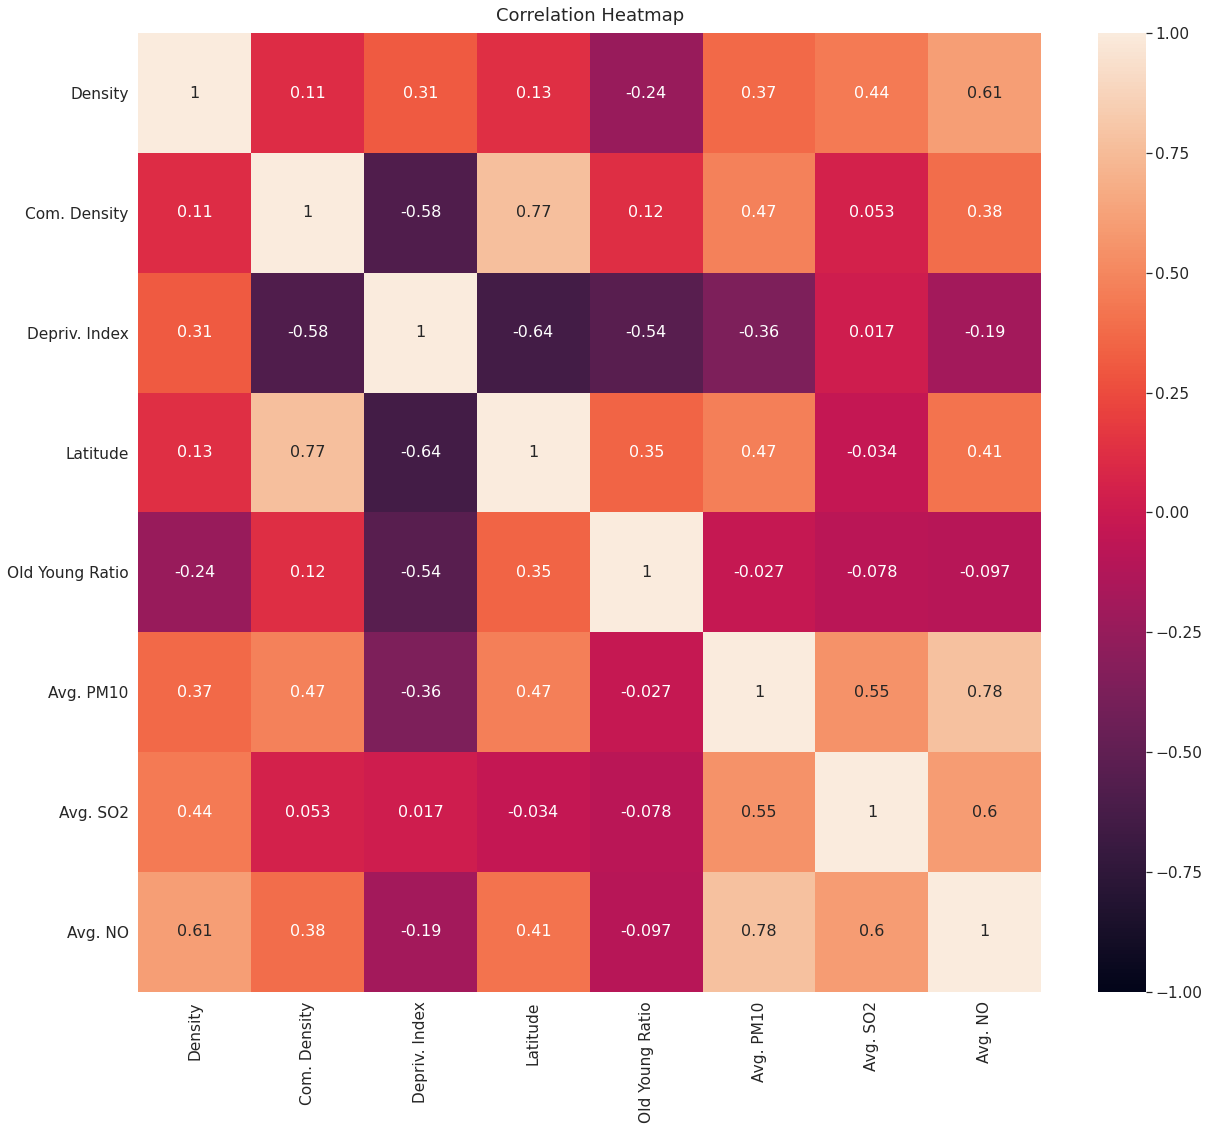

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.33595  0.02016 
    Test set average RMSE:  0.88432  0.08465 

Prediction STD :    1.25880
True value STD :    1.43281
Difference in percentage:   12.14487

             Fullset RMSE:    0.31555
                       R2:    0.95150


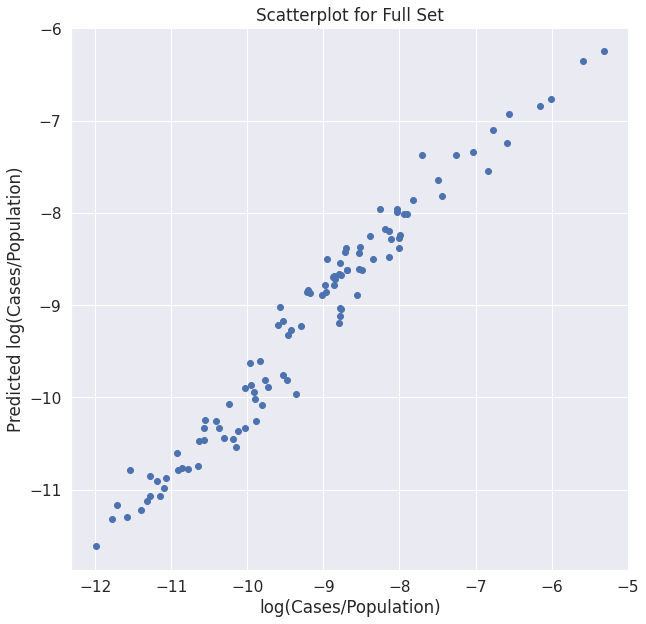

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07436 +/- 0.00827
Feature:                   Com. Density, Score: 0.26273 +/- 0.04601
Feature:                  Depriv. Index, Score: 0.14438 +/- 0.01541
Feature:                       Latitude, Score: 0.71592 +/- 0.09320
Feature:                Old Young Ratio, Score: 0.12193 +/- 0.01437
Feature:                      Avg. PM10, Score: 0.20099 +/- 0.02331
Feature:                       Avg. SO2, Score: 0.10206 +/- 0.01069
Feature:                        Avg. NO, Score: 0.21480 +/- 0.02403


<Figure size 432x288 with 0 Axes>

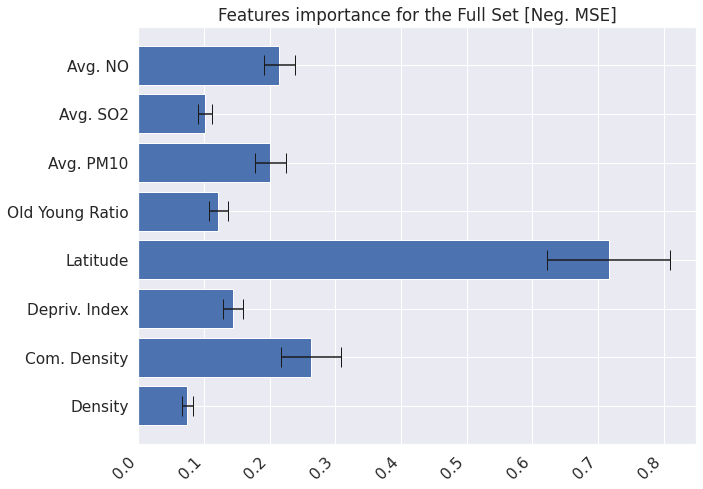

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03622 +/- 0.00403
Feature:                   Com. Density, Score: 0.12798 +/- 0.02241
Feature:                  Depriv. Index, Score: 0.07033 +/- 0.00750
Feature:                       Latitude, Score: 0.34873 +/- 0.04540
Feature:                Old Young Ratio, Score: 0.05939 +/- 0.00700
Feature:                      Avg. PM10, Score: 0.09791 +/- 0.01135
Feature:                       Avg. SO2, Score: 0.04972 +/- 0.00521
Feature:                        Avg. NO, Score: 0.10463 +/- 0.01171


<Figure size 432x288 with 0 Axes>

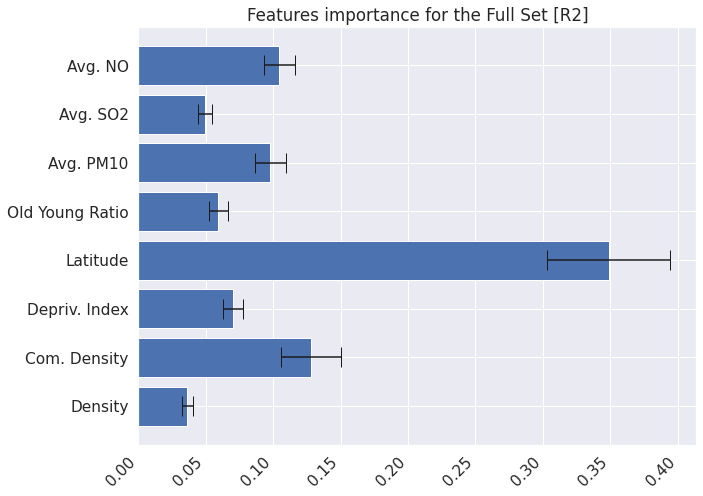

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.31385
                       R2:    0.95222


<Figure size 432x288 with 0 Axes>

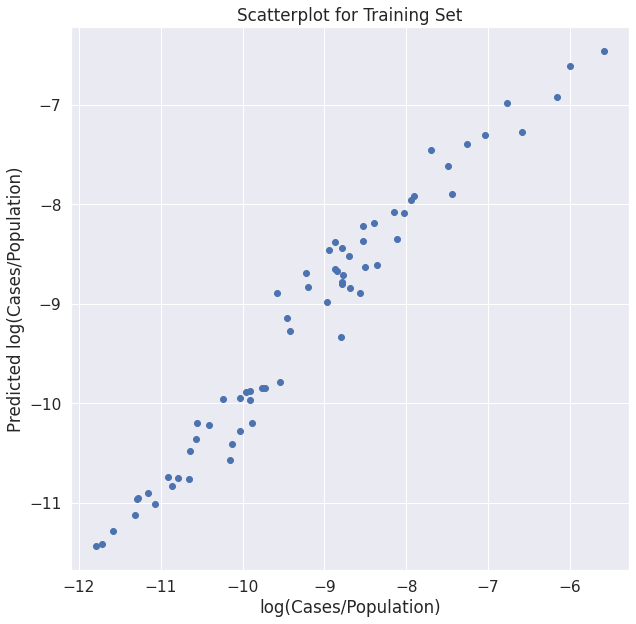

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.96961
                       R2:    0.53855


<Figure size 432x288 with 0 Axes>

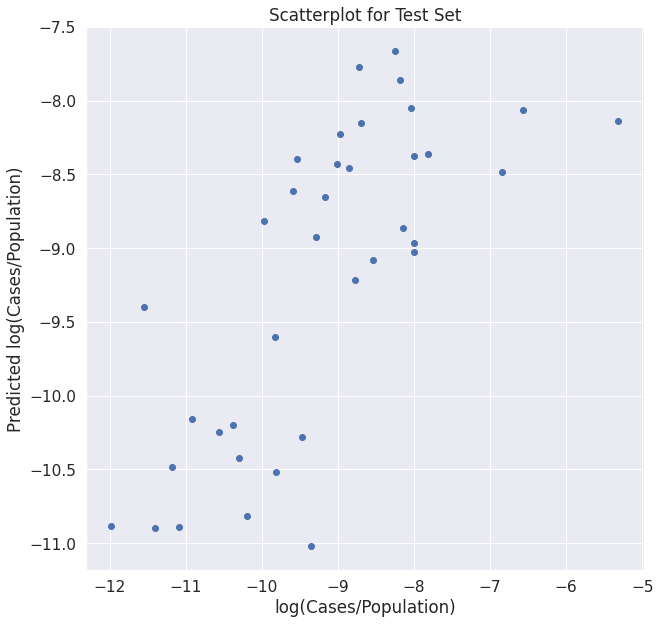

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.11251 +/- 0.08881
Feature:                       Latitude, Score: 0.46765 +/- 0.14475
Feature:                Old Young Ratio, Score: 0.04658 +/- 0.02296
Feature:                      Avg. PM10, Score: 0.07480 +/- 0.04998
Feature:                        Avg. NO, Score: 0.08033 +/- 0.05240


<Figure size 432x288 with 0 Axes>

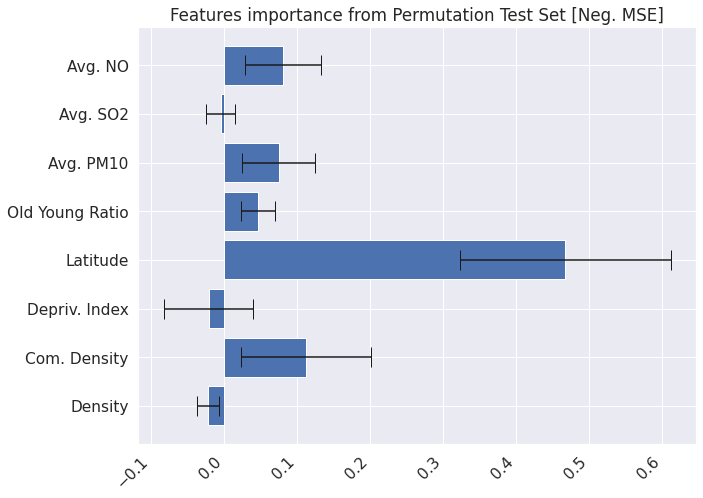

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.05522 +/- 0.04359
Feature:                       Latitude, Score: 0.22954 +/- 0.07105
Feature:                Old Young Ratio, Score: 0.02287 +/- 0.01127
Feature:                      Avg. PM10, Score: 0.03671 +/- 0.02453
Feature:                        Avg. NO, Score: 0.03943 +/- 0.02572


<Figure size 432x288 with 0 Axes>

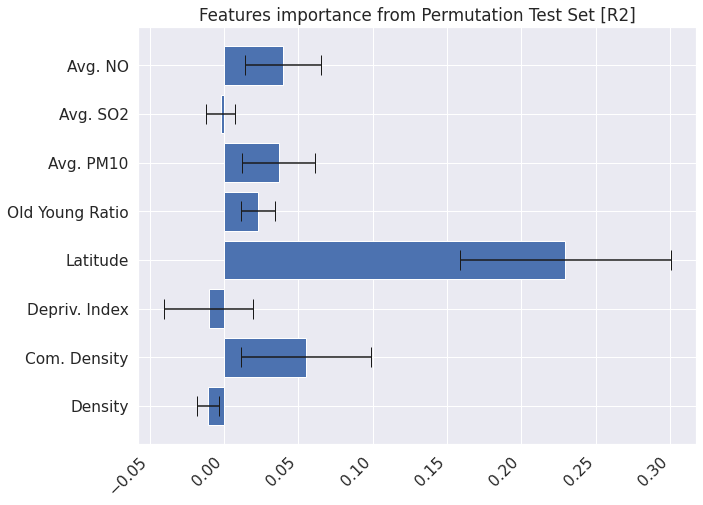

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07768 +/- 0.00901
Feature:                   Com. Density, Score: 0.24943 +/- 0.04365
Feature:                  Depriv. Index, Score: 0.20317 +/- 0.03464
Feature:                       Latitude, Score: 0.58763 +/- 0.08976
Feature:                Old Young Ratio, Score: 0.07940 +/- 0.01463
Feature:                      Avg. PM10, Score: 0.15712 +/- 0.02663
Feature:                       Avg. SO2, Score: 0.08021 +/- 0.00998
Feature:                        Avg. NO, Score: 0.17052 +/- 0.02632


<Figure size 432x288 with 0 Axes>

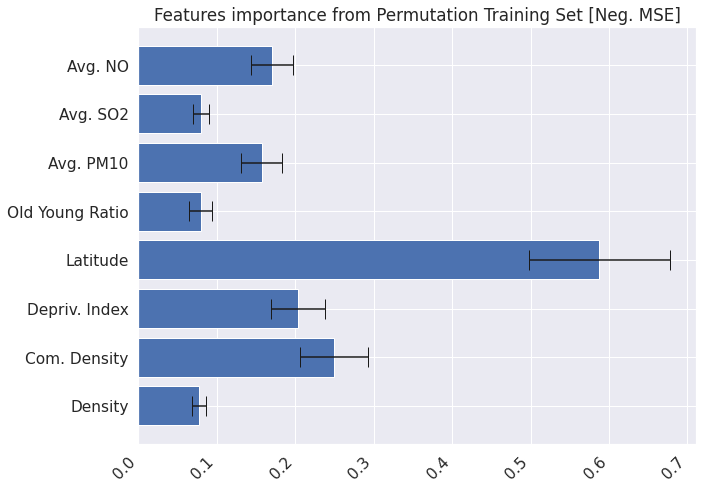

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03768 +/- 0.00437
Feature:                   Com. Density, Score: 0.12099 +/- 0.02117
Feature:                  Depriv. Index, Score: 0.09855 +/- 0.01680
Feature:                       Latitude, Score: 0.28504 +/- 0.04354
Feature:                Old Young Ratio, Score: 0.03852 +/- 0.00709
Feature:                      Avg. PM10, Score: 0.07621 +/- 0.01292
Feature:                       Avg. SO2, Score: 0.03891 +/- 0.00484
Feature:                        Avg. NO, Score: 0.08271 +/- 0.01277


<Figure size 432x288 with 0 Axes>

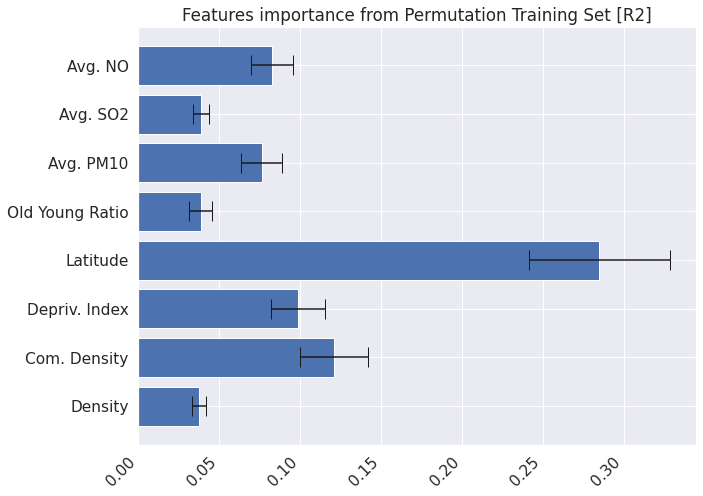

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36338  0.02060 
    Test set average RMSE:  0.97889  0.10724 

Prediction STD :    1.25397
True value STD :    1.43281
Difference in percentage:   12.48187

             Fullset RMSE:    0.34124
                       R2:    0.94328


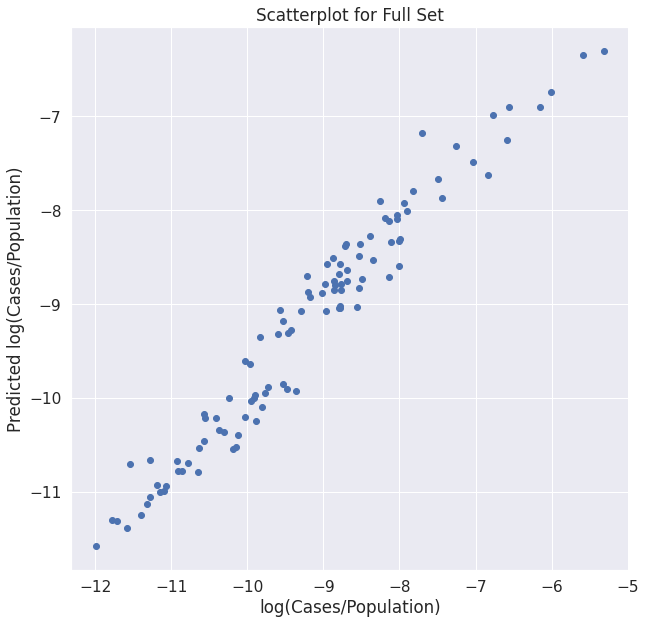

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06398 +/- 0.00641
Feature:                   Com. Density, Score: 1.55468 +/- 0.25794
Feature:                  Depriv. Index, Score: 0.09140 +/- 0.01070
Feature:                Old Young Ratio, Score: 0.23235 +/- 0.02854
Feature:                      Avg. PM10, Score: 0.25999 +/- 0.03343
Feature:                       Avg. SO2, Score: 0.13959 +/- 0.01545
Feature:                        Avg. NO, Score: 0.31987 +/- 0.03415


<Figure size 432x288 with 0 Axes>

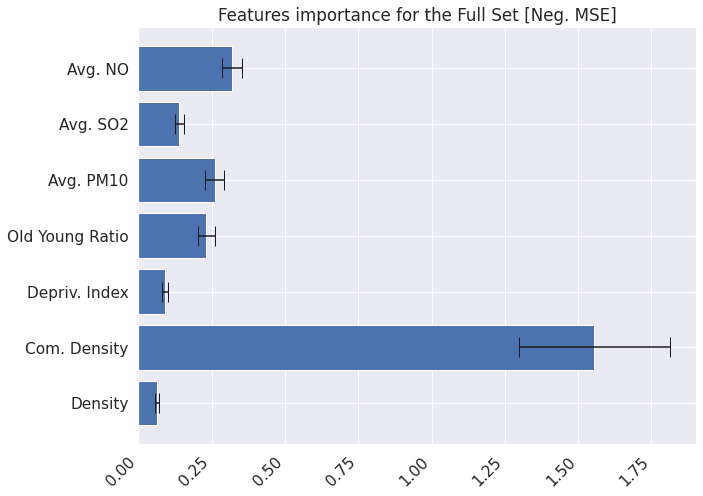

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03116 +/- 0.00312
Feature:                   Com. Density, Score: 0.75729 +/- 0.12565
Feature:                  Depriv. Index, Score: 0.04452 +/- 0.00521
Feature:                Old Young Ratio, Score: 0.11318 +/- 0.01390
Feature:                      Avg. PM10, Score: 0.12664 +/- 0.01628
Feature:                       Avg. SO2, Score: 0.06800 +/- 0.00753
Feature:                        Avg. NO, Score: 0.15581 +/- 0.01664


<Figure size 432x288 with 0 Axes>

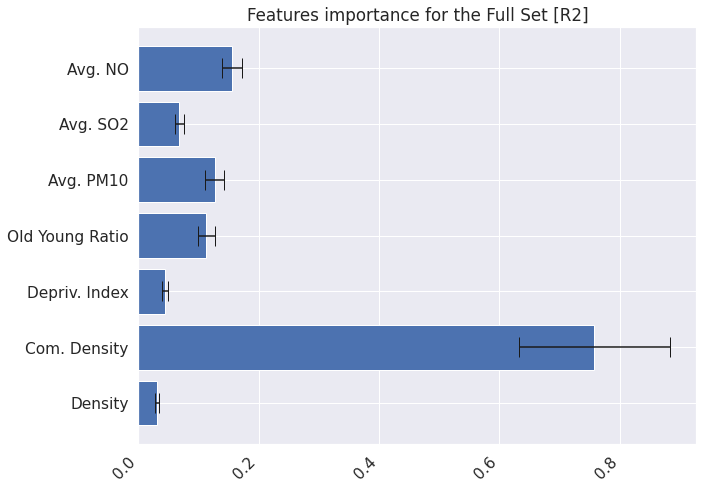

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33870
                       R2:    0.93427


<Figure size 432x288 with 0 Axes>

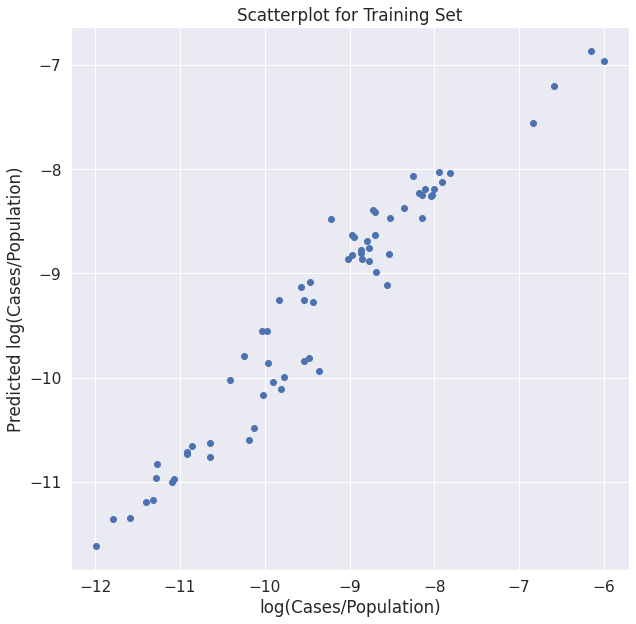

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.04892
                       R2:    0.56620


<Figure size 432x288 with 0 Axes>

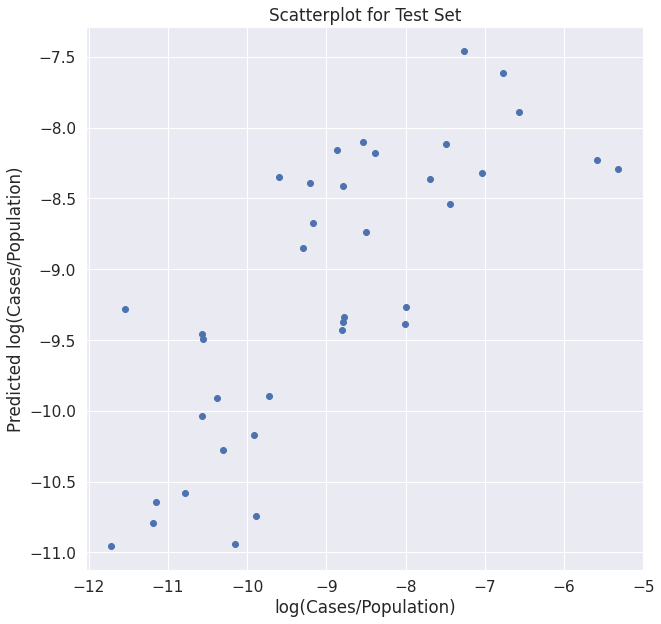

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 1.56253 +/- 0.38141
Feature:                  Depriv. Index, Score: 0.08584 +/- 0.03893
Feature:                Old Young Ratio, Score: 0.07634 +/- 0.05065
Feature:                      Avg. PM10, Score: 0.12556 +/- 0.06235
Feature:                        Avg. NO, Score: 0.18322 +/- 0.08655


<Figure size 432x288 with 0 Axes>

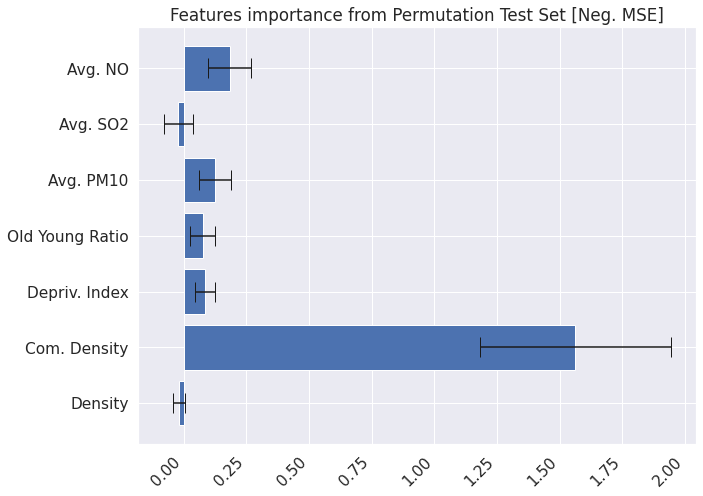

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.61607 +/- 0.15038
Feature:                  Depriv. Index, Score: 0.03385 +/- 0.01535
Feature:                Old Young Ratio, Score: 0.03010 +/- 0.01997
Feature:                      Avg. PM10, Score: 0.04951 +/- 0.02458
Feature:                        Avg. NO, Score: 0.07224 +/- 0.03412


<Figure size 432x288 with 0 Axes>

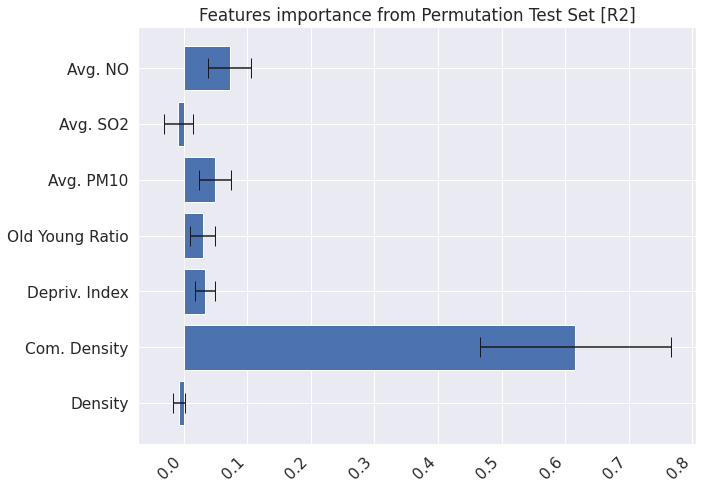

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06359 +/- 0.00913
Feature:                   Com. Density, Score: 1.69244 +/- 0.27838
Feature:                  Depriv. Index, Score: 0.10207 +/- 0.01466
Feature:                Old Young Ratio, Score: 0.17123 +/- 0.03359
Feature:                      Avg. PM10, Score: 0.11752 +/- 0.02467
Feature:                       Avg. SO2, Score: 0.09783 +/- 0.01516
Feature:                        Avg. NO, Score: 0.15639 +/- 0.02925


<Figure size 432x288 with 0 Axes>

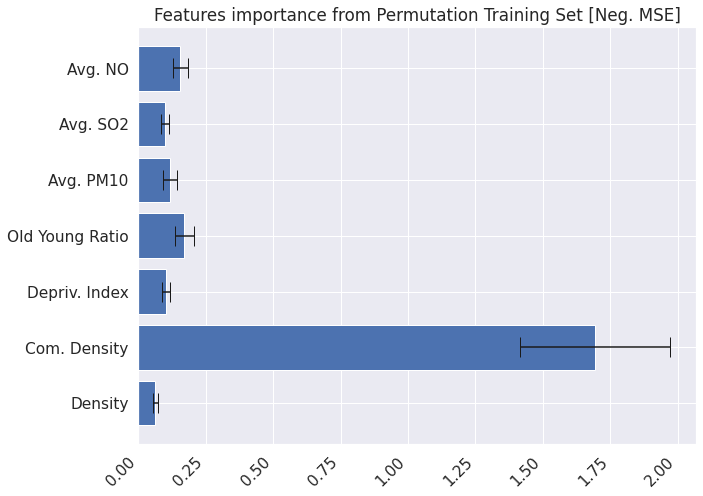

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03643 +/- 0.00523
Feature:                   Com. Density, Score: 0.96968 +/- 0.15950
Feature:                  Depriv. Index, Score: 0.05848 +/- 0.00840
Feature:                Old Young Ratio, Score: 0.09810 +/- 0.01925
Feature:                      Avg. PM10, Score: 0.06733 +/- 0.01413
Feature:                       Avg. SO2, Score: 0.05605 +/- 0.00869
Feature:                        Avg. NO, Score: 0.08960 +/- 0.01676


<Figure size 432x288 with 0 Axes>

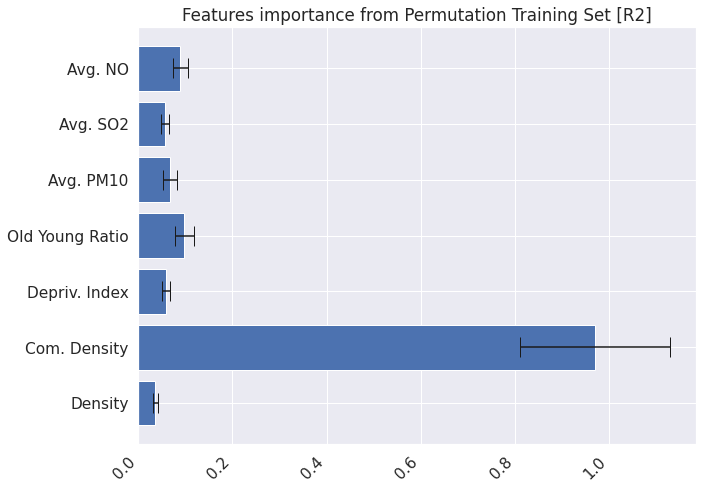

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37122  0.02146 
    Test set average RMSE:  1.03763  0.09627 

Prediction STD :    1.21419
True value STD :    1.43281
Difference in percentage:   15.25808

             Fullset RMSE:    0.35607
                       R2:    0.93824


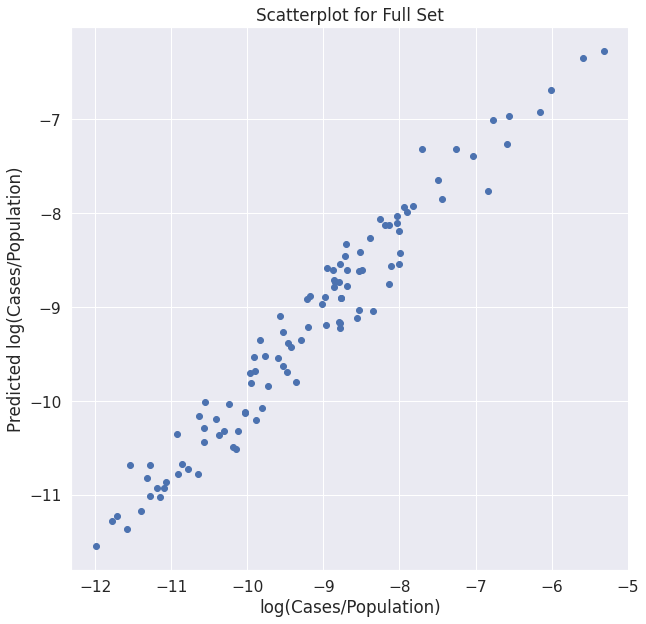

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12690 +/- 0.01295
Feature:                  Depriv. Index, Score: 0.62038 +/- 0.07897
Feature:                Old Young Ratio, Score: 0.21118 +/- 0.02430
Feature:                      Avg. PM10, Score: 0.43953 +/- 0.05279
Feature:                       Avg. SO2, Score: 0.22168 +/- 0.02147
Feature:                        Avg. NO, Score: 0.58183 +/- 0.07101


<Figure size 432x288 with 0 Axes>

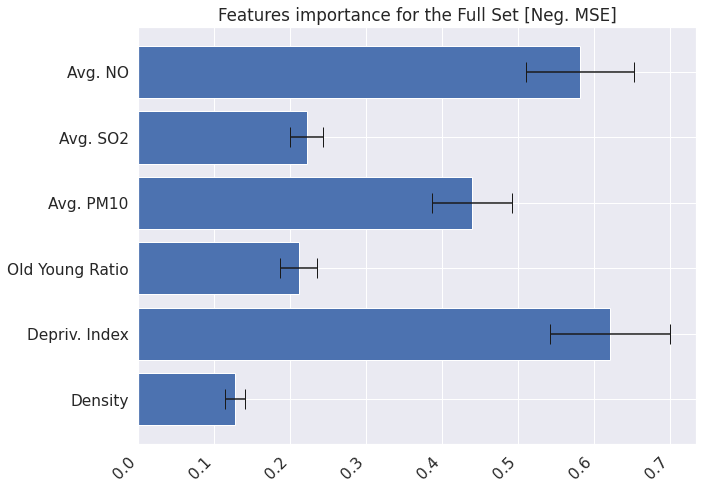

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06181 +/- 0.00631
Feature:                  Depriv. Index, Score: 0.30219 +/- 0.03847
Feature:                Old Young Ratio, Score: 0.10287 +/- 0.01183
Feature:                      Avg. PM10, Score: 0.21410 +/- 0.02571
Feature:                       Avg. SO2, Score: 0.10798 +/- 0.01046
Feature:                        Avg. NO, Score: 0.28341 +/- 0.03459


<Figure size 432x288 with 0 Axes>

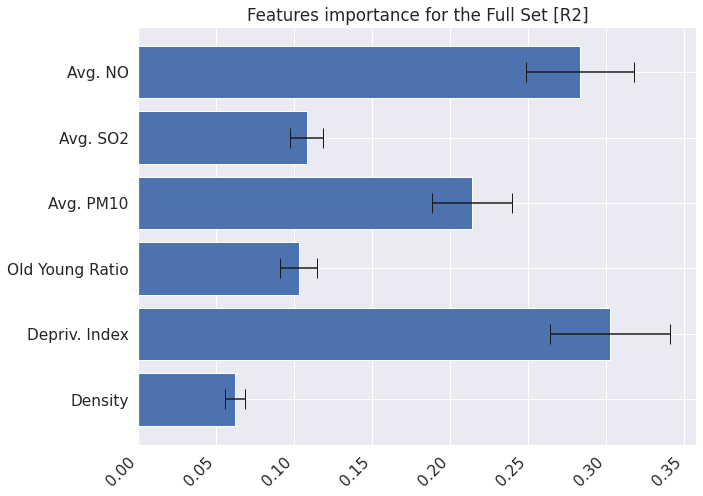

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35128
                       R2:    0.92822


<Figure size 432x288 with 0 Axes>

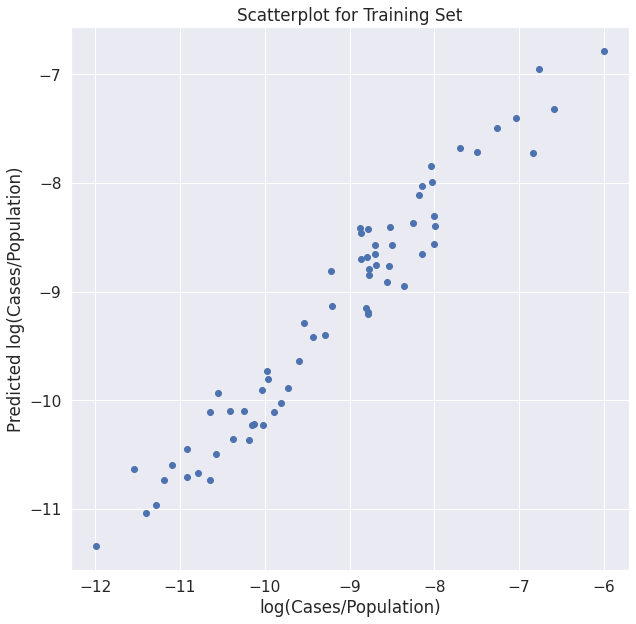

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.18878
                       R2:    0.46813


<Figure size 432x288 with 0 Axes>

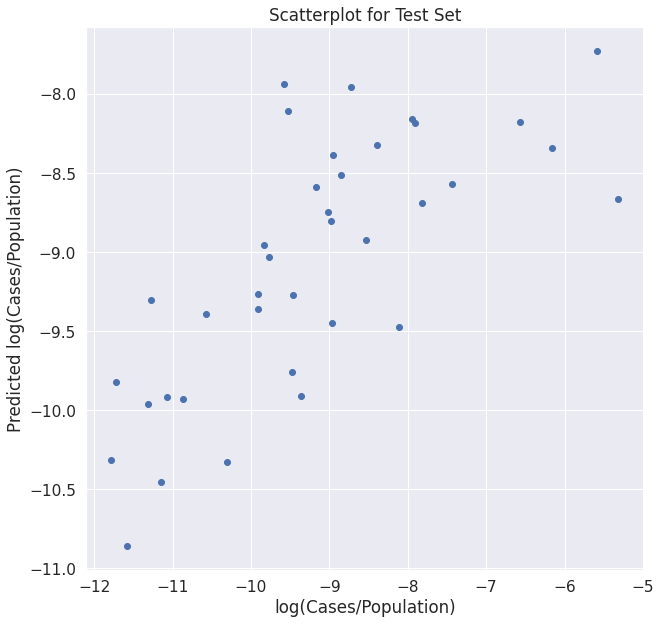

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.32491 +/- 0.11349
Feature:                Old Young Ratio, Score: 0.03777 +/- 0.08434
Feature:                      Avg. PM10, Score: 0.52997 +/- 0.15453
Feature:                       Avg. SO2, Score: 0.04320 +/- 0.04640
Feature:                        Avg. NO, Score: 0.64659 +/- 0.17801


<Figure size 432x288 with 0 Axes>

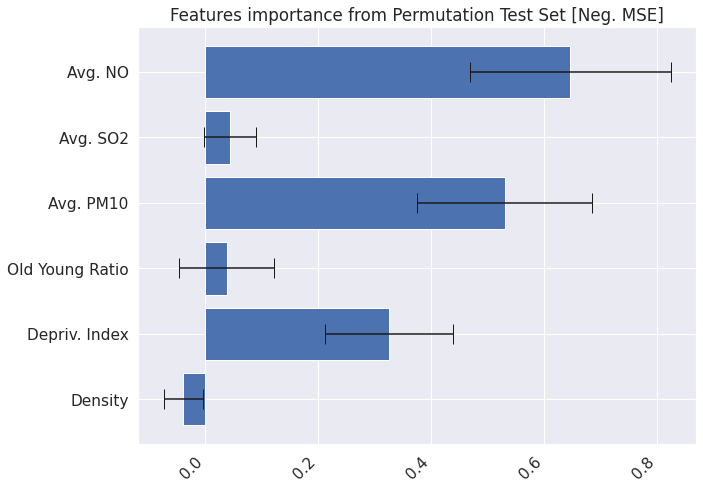

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.12228 +/- 0.04272
Feature:                Old Young Ratio, Score: 0.01421 +/- 0.03174
Feature:                      Avg. PM10, Score: 0.19946 +/- 0.05816
Feature:                       Avg. SO2, Score: 0.01626 +/- 0.01746
Feature:                        Avg. NO, Score: 0.24335 +/- 0.06700


<Figure size 432x288 with 0 Axes>

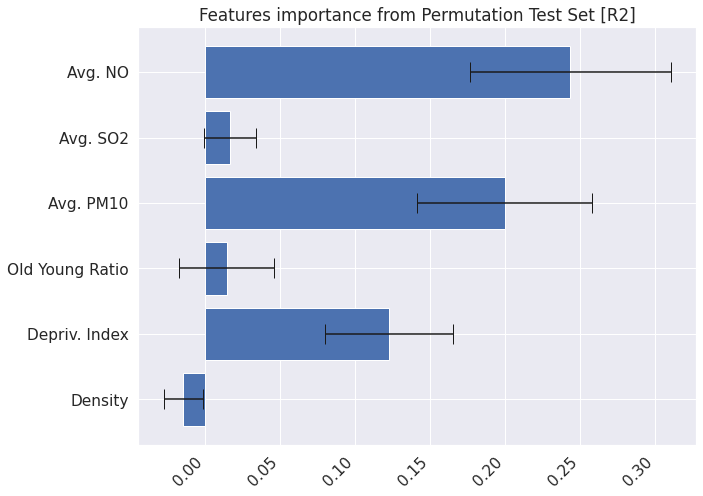

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09772 +/- 0.01075
Feature:                  Depriv. Index, Score: 0.35691 +/- 0.04955
Feature:                Old Young Ratio, Score: 0.29315 +/- 0.04943
Feature:                      Avg. PM10, Score: 0.40393 +/- 0.06584
Feature:                       Avg. SO2, Score: 0.17392 +/- 0.01950
Feature:                        Avg. NO, Score: 0.34793 +/- 0.05333


<Figure size 432x288 with 0 Axes>

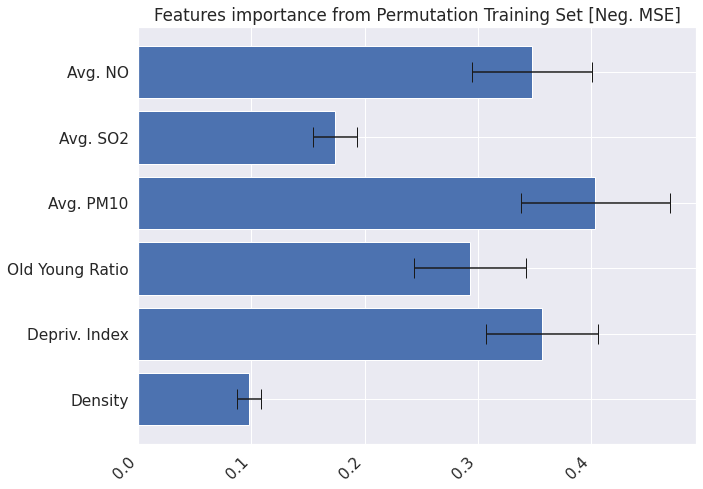

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05684 +/- 0.00625
Feature:                  Depriv. Index, Score: 0.20760 +/- 0.02882
Feature:                Old Young Ratio, Score: 0.17052 +/- 0.02875
Feature:                      Avg. PM10, Score: 0.23496 +/- 0.03829
Feature:                       Avg. SO2, Score: 0.10116 +/- 0.01134
Feature:                        Avg. NO, Score: 0.20238 +/- 0.03102


<Figure size 432x288 with 0 Axes>

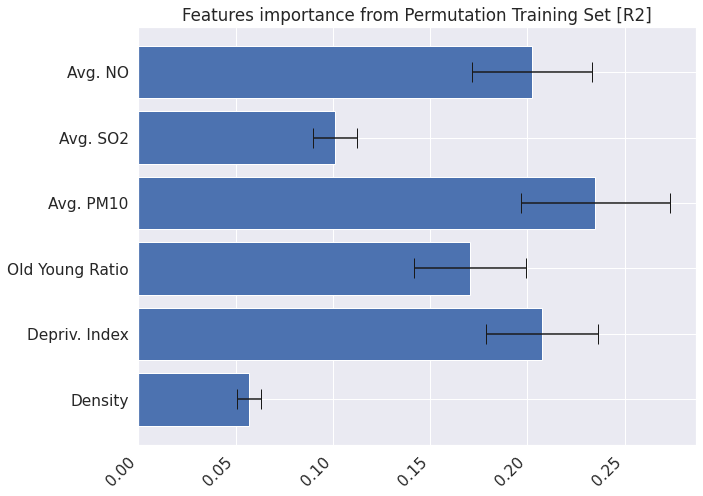

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}


In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.33116 +/-  0.02058 
    Test set average RMSE:  0.89438 +/-  0.09475 
  Training set average R2:  0.94636 +/-  0.00466 
      Test set average R2:  0.59251 +/-  0.06808 
Taining:
             Density ,    0.07332 +/-    0.01153 ,   -0.00720 +/-    0.01094 ,    0.00000 ,    0.00000 ,    0.00000 ,    1.00000
        Com. Density ,    0.22709 +/-    0.03932 ,    0.05644 +/-    0.02770 ,    0.00000 ,   49.00000 ,    0.00000 ,   72.50000
       Depriv. Index ,    0.14482 +/-    0.02834 ,    0.02437 +/-    0.01727 ,    0.00000 ,    2.00000 ,    0.00000 ,    4.00000
            Latitude ,    0.67103 +/-    0.08627 ,    0.28036 +/-    0.05046 ,  100.00000 ,    0.00000 ,  100.00000 ,    0.00000
     Old Young Ratio ,    0.10288 +/-    0.01987 ,    0.00703 +/-    0.01338 ,    0.00000 ,    0.00000 ,    0.00000 ,    3.50000
           Avg. PM10 ,    0.18782 +/-    0.04611 ,    0

<Figure size 720x720 with 0 Axes>

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...


In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)